# ЛР 2. Линейная регрессия

## Подготовка

Импортируем все необходимые для лабораторной библиотеки и определим функцию SMAPE.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor, Ridge, RANSACRegressor
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt

import warnings  
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [2]:
EPSILON = 1e-10
def loss(actual: np.ndarray, predicted: np.ndarray):
    return np.mean(2.0 * np.abs(actual - predicted) / ((np.abs(actual) + np.abs(predicted)) + EPSILON))

scorer = make_scorer(loss, greater_is_better=False)

Загрузим тренировочную и тестовую выборки из файла.

In [3]:
with open('7.txt', 'r') as data:
    features = int(data.readline())
    
    train_count = int(data.readline())
    train = []
    for i in range(train_count):
        train.append([int(x) for x in data.readline().split()])
    
    test_count = int(data.readline())
    test = []
    for i in range(test_count):
        test.append([int(x) for x in data.readline().split()])

train = pd.DataFrame(train)
test = pd.DataFrame(test)

Отделим признаки от классов в обеих выборках.

In [4]:
train_X, train_y = train.drop(features, axis=1), train[features]
test_X, test_y = test.drop(features, axis=1), test[features]

train_X = train_X.to_numpy()
train_y = train_y.to_numpy().reshape(-1, 1)
test_X = test_X.to_numpy()
test_y = test_y.to_numpy().reshape(-1, 1)

Нормализуем полученные данные.

In [5]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

train_X, train_y = scaler_X.fit_transform(train_X), scaler_y.fit_transform(train_y)
test_X, test_y = scaler_X.transform(test_X), scaler_y.transform(test_y)
train_y, test_y = train_y.reshape(-1), test_y.reshape(-1)

## 1. Метод наименьших квадратов

In [6]:
parameters = {
    "alpha": np.arange(0.1, 20, 0.1),
    "solver": ['svd']
}

linear_model = Ridge()
grid = GridSearchCV(linear_model, parameters, scoring=scorer)
grid.fit(train_X, train_y)
best_params = grid.best_params_
linear_loss_train, linear_loss_test = [], []
print('Лучшие параметры для SGD: ', best_params)

Лучшие параметры для SGD:  {'alpha': 0.1, 'solver': 'svd'}


In [7]:
max_iter_range = np.arange(11, 41, 2)
for max_iter in max_iter_range:
    best_params['max_iter'] = max_iter
    linear_model = Ridge()
    linear_model.set_params(**best_params)
    linear_model.fit(train_X, train_y)
    linear_loss_train.append(loss(train_y, linear_model.predict(train_X)))
    linear_loss_test.append(loss(test_y, linear_model.predict(test_X)))

print(f'Ошибка на тренировочных данных: {min(linear_loss_train):.2%}')
print(f'Ошибка на тестовых данных:      {min(linear_loss_test):.2%}')

Ошибка на тренировочных данных: 1.76%
Ошибка на тестовых данных:      0.85%


Построим график зависимости функции потерь от максимального количества итераций.

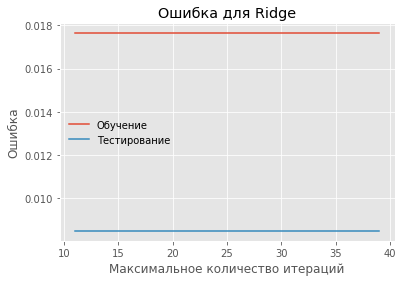

In [8]:
plt.title("Ошибка для Ridge")
plt.xlabel("Максимальное количество итераций")
plt.ylabel("Ошибка")
plt.plot(max_iter_range, linear_loss_train, label='Обучение')
plt.plot(max_iter_range, linear_loss_test, label='Тестирование')
plt.legend(loc='center left', frameon=False)
plt.show()

## 2. Градиентный спуск

Подберём наилучшие параметры для стохастического градиентного спуска.

In [9]:
parameters = {
    'penalty': ('l1', 'l2', 'elasticnet'), 
    'alpha': np.linspace(0.000001, 0.000201, 5), 
    'learning_rate': ['adaptive'],
    'eta0': np.linspace(0.0001, 0.1001, 5)
}

sgd_model = SGDRegressor()
grid = GridSearchCV(sgd_model, parameters, scoring=scorer)
grid.fit(train_X, train_y)
best_params = grid.best_params_
sgd_loss_train, sgd_loss_test = [], []
print('Лучшие параметры для SGD: ', best_params)

Лучшие параметры для SGD:  {'alpha': 0.000151, 'eta0': 0.025099999999999997, 'learning_rate': 'adaptive', 'penalty': 'elasticnet'}


Теперь посмотрим, как функция потерь будет зависеть от максимального количества итераций спуска.

In [10]:
max_iter_range = np.arange(11, 41, 2)
for max_iter in max_iter_range:
    best_params['max_iter'] = max_iter
    sgd = SGDRegressor()
    sgd.set_params(**best_params)
    sgd.fit(train_X, train_y)
    sgd_loss_train.append(loss(train_y, sgd.predict(train_X)))
    sgd_loss_test.append(loss(test_y, sgd.predict(test_X)))
    
print(f'Ошибка на тренировочных данных: {min(sgd_loss_train):.2%}')
print(f'Ошибка на тестовых данных:      {min(sgd_loss_test):.2%}')

Ошибка на тренировочных данных: 2.29%
Ошибка на тестовых данных:      1.82%


Построим график зависимости функции потерь от максимального количества итераций.

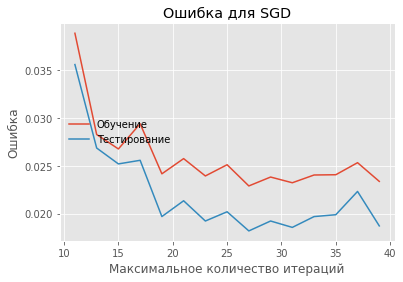

In [11]:
plt.title("Ошибка для SGD")
plt.xlabel("Максимальное количество итераций")
plt.ylabel("Ошибка")
plt.plot(max_iter_range, sgd_loss_train, label='Обучение')
plt.plot(max_iter_range, sgd_loss_test, label='Тестирование')
plt.legend(loc='center left', frameon=False)
plt.show()

## 3. RANSAC

In [12]:
parameters = {
    'max_trials': np.arange(1, 201, 10),
    'min_samples': np.arange(0.1, 1, 0.1)
}

ransac_model = RANSACRegressor()
grid = GridSearchCV(ransac_model, parameters, scoring=scorer)
grid.fit(train_X, train_y)
best_params = grid.best_params_
ransac_loss_train, ransac_loss_test = [], []
print('Лучшие параметры для RANSAC: ', best_params)

Лучшие параметры для RANSAC:  {'max_trials': 61, 'min_samples': 0.2}


In [13]:
max_iter_range = np.arange(1, 201, 2)
for max_iter in max_iter_range:
    best_params['max_trials'] = max_iter
    ransac = RANSACRegressor()
    ransac.set_params(**best_params)
    ransac.fit(train_X, train_y)
    ransac_loss_train.append(loss(train_y, ransac.predict(train_X)))
    ransac_loss_test.append(loss(test_y, ransac.predict(test_X)))
    
print(f'Ошибка на тренировочных данных: {min(ransac_loss_train):.2%}')
print(f'Ошибка на тестовых данных:      {min(ransac_loss_test):.2%}')

Ошибка на тренировочных данных: 1.76%
Ошибка на тестовых данных:      0.86%


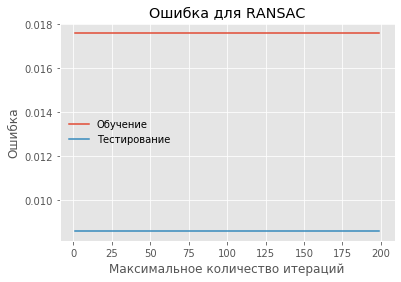

In [14]:
plt.title("Ошибка для RANSAC")
plt.xlabel("Максимальное количество итераций")
plt.ylabel("Ошибка")
plt.plot(max_iter_range, ransac_loss_train, label='Обучение')
plt.plot(max_iter_range, ransac_loss_test, label='Тестирование')
plt.legend(loc='center left', frameon=False)
plt.show()